# Credit Card Fraud Detection System  
  
## Project Prototype
  
  
Author: Marco Fontana

In [ ]:
# Install required libraries (if not already installed, please uncomment the following line and execute it)
!pip install numpy pandas tensorflow scikit-learn imbalanced-learn matplotlib

In [48]:
# Import required libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

In [49]:
# Load the dataset
df = pd.read_csv('creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [50]:
print("Dataset classes items:" , df.shape)

# Convert the Class column to a NumPy array
class_array = df['Class'].to_numpy()

# Calculate the percentage of Class 1 records (frauds)
percentage_class_1 = (np.sum(class_array == 1) / len(class_array)) * 100

print(f"Percentage of Class 1 records: {percentage_class_1:.3f}%")

Dataset classes items: (284807, 31)
Percentage of Class 1 records: 0.173%


### Class for calculating the time taken to execute the code

In [51]:
import time

class Timer:
    def __init__(self):
        """Initialize the timer with no start time"""
        self.start_time = None

    def start(self):
        """Start the timer"""
        self.start_time = time.time()        

    def elapsed(self):
        """Calculate the time elapsed since the timer was started"""
        if self.start_time is None:
            raise ValueError("Timer has not been started. Call `start()` before `elapsed()`")
        elapsed_time = time.time() - self.start_time
        return elapsed_time

    def stop(self):
        """Stop the timer and reset the start_time"""
        self.start_time = None

# Create the Timer object
timer = Timer()

### Balancing the dataset

The dataset is very unbalanced, so I will use the SMOTE technique to make the two classes equivalent in the number of records.  
The balancing of the dataset is done after its division into training and test data, so that the latter contain no ‘synthetic’ data.

Class Distribution Before SMOTE:
Class
0    284315
1       492
Name: count, dtype: int64


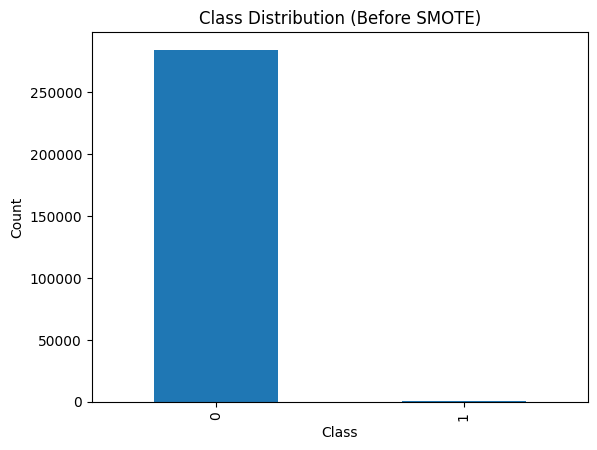

Training Class Distribution Before SMOTE:
Class
0    227451
1       394
Name: count, dtype: int64
Training Class Distribution After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


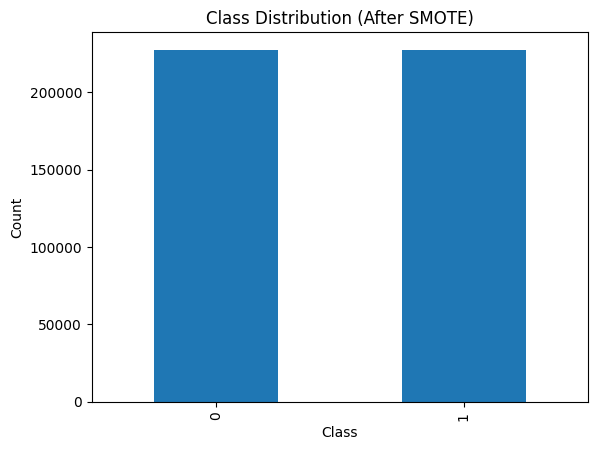

In [52]:
# Display class distribution
print("Class Distribution Before SMOTE:")
print(df['Class'].value_counts())
df['Class'].value_counts().plot(kind='bar', title='Class Distribution (Before SMOTE)', xlabel='Class', ylabel='Count')
plt.show()

# Separate features and labels
X = df.drop(columns=['Class'], axis=1)
y = df['Class']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution in training set
print("Training Class Distribution Before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Training Class Distribution After SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Visualize the balanced class distribution
pd.Series(y_train_smote).value_counts().plot(kind='bar', title='Class Distribution (After SMOTE)', xlabel='Class', ylabel='Count')
plt.show()

In [53]:
# Start the timer
timer.start()

# Train a Random Forest Classifier on the balanced dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

Elapsed time: 480.90 seconds


Elapsed time: 0.45 seconds
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.83      0.84      0.83        97

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.999420666409185


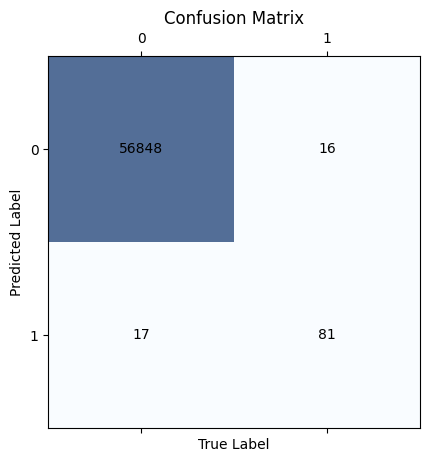

In [54]:
# Start the timer
timer.start()

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

# Evaluate the model
print("Classification Report:\n", classification_report(y_pred, y_test))
print("Accuracy:", accuracy_score(y_pred, y_test))

# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap='Blues', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()


In [55]:
# Build the Autoencoder model
def build_autoencoder(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        # Encoder
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),  # Bottleneck (compressed representation)
        # Decoder
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')  # Output layer matches input
    ])
    return model

In [56]:
# Separate features and labels
# The Class feature is not required in an unsupervised learning model
X = df.drop(columns=['Class'], axis=1)  # Features
y = df['Class']  # Labels

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Separate normal (non-fraudulent) transactions for training the Autoencoder
X_normal = X_normalized[y == 0]

# Split the normal transactions into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# Initialize the Autoencoder
input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Start the timer
timer.start()

# Train the Autoencoder
history = autoencoder.fit(
    X_train, X_train,  # Input is the same as the target
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=64,
    verbose=1
)   

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

Epoch 1/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.8885 - val_loss: 0.7803
Epoch 2/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7732 - val_loss: 0.7659
Epoch 3/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7595 - val_loss: 0.7561
Epoch 4/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7619 - val_loss: 0.7510
Epoch 5/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7555 - val_loss: 0.7452
Epoch 6/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7401 - val_loss: 0.7425
Epoch 7/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7281 - val_loss: 0.7389
Epoch 8/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7331 - val_loss: 0.7374
Epoch 9/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7384 - val_loss: 0.7369
Epoch 10/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7313 - val_loss: 0.7350
Epoch 11/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7462 - val_loss: 0.7334
Epoch 12/50
3554/3554 ━━━━━━━━

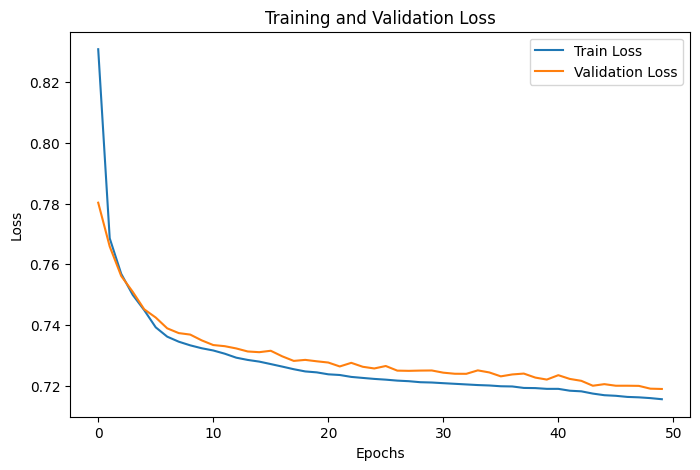

In [57]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 554us/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.10      0.63      0.17       492

    accuracy                           0.99    284807
   macro avg       0.55      0.81      0.58    284807
weighted avg       1.00      0.99      0.99    284807

Confusion Matrix:
 [[281471   2844]
 [   184    308]]
Accuracy: 0.9893682388424442


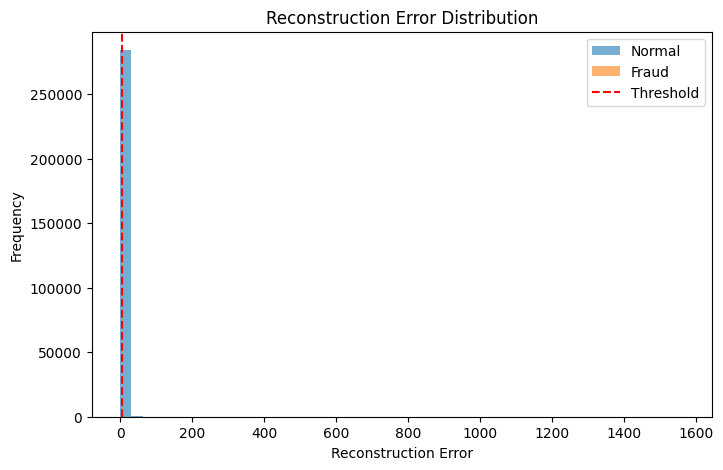

In [58]:
# Use the Autoencoder to calculate reconstruction errors
X_reconstructed = autoencoder.predict(X_normalized)
reconstruction_errors = np.mean(np.square(X_normalized - X_reconstructed), axis=1)

# Set a threshold for anomalies based on normal transactions' errors
threshold = np.percentile(reconstruction_errors[y == 0], 99)  # 98th percentile

# Classify anomalies (fraud) based on reconstruction error
y_pred = (reconstruction_errors > threshold).astype(int)

# Evaluate the results
print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))

# Visualize reconstruction error distributions
plt.figure(figsize=(8, 5))
plt.hist(reconstruction_errors[y == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_errors[y == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

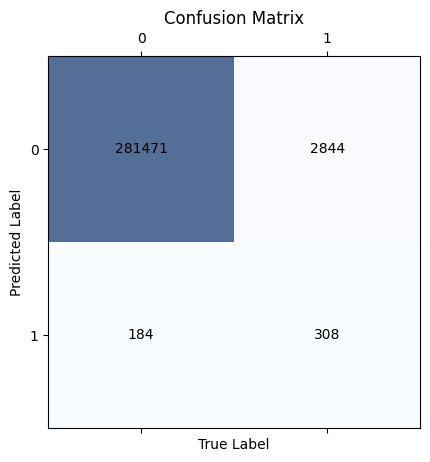

In [59]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.matshow(conf_matrix, cmap='Blues', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()